# Proyecto. Predicción de precios de acciones.

# Video explicativo: 
Todo el contenido del proyecto se explica en el siguiente video: [Youtube](https://youtu.be/CyBd3QswmtE).

## Datos 

Los datos se encuentran en la carpeta `data`, la estructura de carpetas debe ser la siguiente:
```terminal
data
└── stock_market_data
    ├── forbes2000
    │   └── csv
    │       └── IP.csv
    ├── nyse
    │   └── csv
    │       ├── BEN.csv
    │       └── X.csv
    └── sp500
        └── csv
            └── VZ.csv
```
La ruta a leer los datos se establece con la variable `base_path` por lo que si se desea cambiar el archivo con el que se quiera entrenar la red hay que cambiar el valor de `base_path`.



## Descarga de datos
El conjunto completo de datos no se incluyó pues pesa más de 16 GB, el cual consiste de diferentes ejemplos de acciones de diferentes bolsas de valores. En el repositorio se incluyen 4 ejemplos de diferentes bolsas de valores para probar la red.



El conjunto de datos completo se puede descargar desde el siguiente enlace: [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/stock-market-data).


Alternativamente se pueden descargar los datos con el siguiente script:
```python
import kagglehub

#Download latest version
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

print("Path to dataset files:", path)
```


## Lectura de datos
Primero vamos a ponerlo en un dataframe de pandas.


In [97]:
import pandas as pd

base_path = 'data/stock_market_data/nyse/csv/X.csv'


#Otras opciones de CSVs
#base_path = 'data/stock_market_data/sp500/csv/VZ.csv'

#base_path = 'data/stock_market_data/forbes2000/csv/IP.csv'

#base_path = 'data/stock_market_data/nyse/csv/BEN.csv'


# 1) Leer CSV indicando que el día viene primero
df = pd.read_csv(
    base_path,
    parse_dates=['Date'],
    dayfirst=True,           
)

# 2) Ordenar por fecha y fijar índice con respecto a la fecha
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# 3) Verifica columnas y elimininamos 'Adjusted Close'
print("Columnas originales:", df.columns.tolist())
df.drop(columns=['Adjusted Close'], inplace=True)

print(df.head())
print("Columnas finales:", df.columns.tolist())

print(df.tail())


Columnas originales: ['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']
               Low    Open  Volume    High   Close
Date                                              
1991-04-12  20.000  20.000  482100  23.500  22.750
1991-04-15  23.125  23.125  392800  26.125  26.000
1991-04-16  25.000  26.000  384300  26.375  25.125
1991-04-17  25.500  25.500  205400  26.250  25.750
1991-04-18  25.750  25.750  214000  27.375  26.625
Columnas finales: ['Low', 'Open', 'Volume', 'High', 'Close']
                  Low       Open   Volume       High      Close
Date                                                           
2022-12-06  26.389999  26.660000  7547100  27.219999  27.200001
2022-12-07  26.620001  26.780001  8199600  27.639999  26.650000
2022-12-08  26.030001  27.290001  7560700  27.430000  26.110001
2022-12-09  25.389999  26.000000  5791600  26.690001  25.410000
2022-12-12  24.905001  25.370001  1889016  25.565300  25.110001


Vamos a ordenar por fecha y a definir nuestras caracteristicas de entrada:
- `Open`, `High`, `Low`, `Volume`.

Y para la salida
- `Close`.


### Preparación de datos
Primero vamos normalizar los datos de las caracteristicas de entrada, despues creamos ventanas de tiempo para las caracteristicas de entrada con tamaño T. 

In [98]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) Parámetros
T = 10                         # largo de la secuencia
features = ['Open','High','Low','Volume']
target   = 'Close'

# 2) Extraer matrices NumPy
data_X = df[features].values   
data_y = df[target].values     


# 3) Normalizar 
scaler = StandardScaler()
data_X = scaler.fit_transform(data_X)


# 4) Construir ventanas deslizantes
X, y = [], []
for i in range(len(df) - T):
    X.append(data_X[i:i+T])       # cada X_i es (T, D)
    y.append(data_y[i+T])         # el cierre “del día siguiente”
X = np.stack(X)                    # forma (N, T, D)
y = np.array(y)                    # forma (N,)

# 5) Convertir a tensores PyTorch
X_tensor = torch.from_numpy(X).float()         
y_tensor = torch.from_numpy(y).float().unsqueeze(1)  # (N,1)



### Separación de datos
Separar los datos en entrenamiento, validación y prueba. 


In [99]:
# 6) Separar train/test 
N = X_tensor.size(0)
# 60% para entrenamiento, 20% validación, 20% test
n_train = int(0.60 * N)
n_val   = int(0.20 * N)
n_test  = N - n_train - n_val

# Crear los TensorDataset correspondientes
train_ds = TensorDataset(X_tensor[:n_train],       y_tensor[:n_train])
val_ds   = TensorDataset(X_tensor[n_train:n_train+n_val],
                         y_tensor[n_train:n_train+n_val])
test_ds  = TensorDataset(X_tensor[n_train+n_val:], y_tensor[n_train+n_val:])

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

print(f"Ejemplares totales: {N}")
print(f"Train: {len(train_ds)}  |  Val: {len(val_ds)}  |  Test: {len(test_ds)}")
print(f"Batches por loader -> Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Ejemplares totales: 7969
Train: 4781  |  Val: 1593  |  Test: 1595
Batches por loader -> Train: 150, Val: 50, Test: 50


# Arquitectura de la red

## Redes recurrentes (RNN)

Una red neuronal recurrente procesa secuencias manteniendo un **estado** oculto que evoluciona en el tiempo:

$$
\mathbf{s}^{(t)} \;=\; f\bigl(\mathbf{s}^{(t-1)},\,\mathbf{x}^{(t)};\,\boldsymbol\theta\bigr)
$$
$$
\mathbf{h}^{(t)} \;=\; g\bigl(\mathbf{s}^{(t)}\bigr)
$$


![RNN](assets/rnn.png "RNN")

donde  
- $\mathbf{x}^{(t)}\in\mathbb R^D$ es la entrada en el paso $t$,  
- $\mathbf{s}^{(t)}\in\mathbb R^H$ es el estado interno (autoconexión),  
- $\mathbf{h}^{(t)}\in\mathbb R^H$ es la salida o la “representación oculta” en $t$,  
- $\theta$ son los parámetros de la red,

En la versión clásica de RNN con activación $\tanh$:

$$
\mathbf{h}^{(t)} \;=\; \tanh\!\bigl(W_h\,\mathbf{h}^{(t-1)} + W_x\,\mathbf{x}^{(t)} + \mathbf{b}\bigr)
$$

## Redes de Memoria a Largo Plazo (LSTM)

Las LSTM añaden un **mecanismo de puertas** para controlar qué información se conserva o descarta en la celda de memoria. Para cada unidad $i$ en el paso $t$:

![LSTM](assets/lstm.png "LSTM")

1. **Puerta de entrada**  
   $$
   g_i^{(t)} 
   = \sigma\!\Bigl(b_i^g + \sum_j U^g_{i,j}\,x_j^{(t)}
                    + \sum_j W^g_{i,j}\,h_j^{(t-1)}\Bigr)
   $$

2. **Puerta de olvido**  
   $$
   f_i^{(t)} 
   = \sigma\!\Bigl(b_i^f + \sum_j U^f_{i,j}\,x_j^{(t)}
                    + \sum_j W^f_{i,j}\,h_j^{(t-1)}\Bigr)
   $$

3. **Puerta de salida**  
   $$
   q_i^{(t)} 
   = \sigma\!\Bigl(b_i^o + \sum_j U^o_{i,j}\,x_j^{(t)}
                    + \sum_j W^o_{i,j}\,h_j^{(t-1)}\Bigr)
   $$

4. **Entrada $x_i$**  
   $$
   a_i^{(t)} 
   = \tanh\!\Bigl(b_i + \sum_j U_{i,j}\,x_j^{(t)}
                      + \sum_j W_{i,j}\,h_j^{(t-1)}\Bigr)
   $$

5. **Estado $s_i$**  
   $$
   s_i^{(t)} 
   = f_i^{(t)} \, s_i^{(t-1)} \;+\; g_i^{(t)} \, a_i^{(t)}
   $$

6. **Cálculo de la salida oculta**  
   $$
   h_i^{(t)} 
   = \tanh\!\bigl(s_i^{(t)}\bigr)\, q_i^{(t)}
   $$

---


### Implementación de la arquitectura:

1. **Entrada**  
   El modelo recibe un lote de secuencias de tamaño `(batch, T, input_dim)`, donde cada secuencia contiene las características diarias (`Open`, `High`, `Low`, `Volume`) durante los últimos T días.

2. **Inicialización del estado interno**  
   Antes de procesar la primera, se generan dos tensores de ceros que representan el **estado oculto** y el **estado de celda** de cada una de las 3 capas LSTM. 

3. **Procesamiento en la LSTM con 3 capas**  
   Las T entradas se alimentan de manera recurrente en la pila de 3 capas LSTM:  
   - En cada paso de tiempo, la capa 1 recibe la entrada del día y el estado oculto y de celda de su paso anterior.  
   - Su salida se convierte en la entrada de la capa 2, junto con su propio estado oculto/celda anterior, y así sucesivamente hasta la capa 3.  

4. **Obtención de la representación final**  
   Tras recorrer toda la secuencia de T pasos, cada capa produce un vector de dimensión `hidden_dim` en cada tiempo. Solo nos interesa la **última** salida de la capa superior, que resume la información de toda la ventana histórica.

5. **Capa lineal de predicción**  
   Ese vector final, que tiene un resumen de lo aprendido, lo usamos con una capa completamente conectada a un escalar. Este valor resultante es la predicción del precio de cierre al día siguiente.

6. **Salida del modelo**  
   Se retorna un tensor de forma `(batch, 1)` con la predicción para cada secuencia del lote.





In [100]:
import torch
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Capa LSTM: recibe secuencias de largo T con input_dim features
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers>1 else 0.0
        )

        # Capa final: de hidden_dim a 1 valor de salida
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch, T, input_dim)
        # h0, c0 se inicializan a cero
        batch_size = x.size(0)
        device = x.device
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=device)

        # LSTM → output: (batch, T, hidden_dim)
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Tomamos sólo la salida en el último paso de tiempo
        last = out[:, -1, :]  # forma (batch, hidden_dim)

        y_pred = self.linear(last)  # forma (batch, 1)
        return y_pred


La elección de los hiperparámetros es explicada en el video.

Epoch 10 — Train Loss: 16.2066 | Val Loss: 11.4829
Epoch 20 — Train Loss: 4.6913 | Val Loss: 1.0542
Epoch 30 — Train Loss: 2.3667 | Val Loss: 1.0701
Epoch 40 — Train Loss: 1.9369 | Val Loss: 0.9026
Epoch 50 — Train Loss: 1.5897 | Val Loss: 0.8242
Epoch 60 — Train Loss: 1.3437 | Val Loss: 0.9544
Epoch 70 — Train Loss: 1.2472 | Val Loss: 0.7651
Epoch 80 — Train Loss: 1.2040 | Val Loss: 0.8739
Epoch 90 — Train Loss: 1.1339 | Val Loss: 0.8022
Epoch 100 — Train Loss: 1.1342 | Val Loss: 0.8177


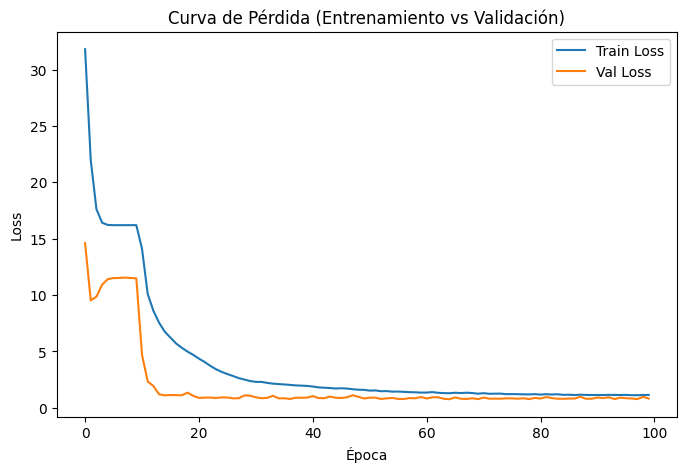

In [101]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ── 0) Fijar semilla para reproducibilidad ────────────────────────────────────
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


# 1) Hiperparámetros
input_dim  = len(features)  
hidden_dim = 64
num_layers = 3
dropout    = 0.2
lr         = 1e-3
epochs     = 100
batch_size = 32



# 2) Modelo, pérdida y optimizador
model = StockLSTM(input_dim, hidden_dim, num_layers, dropout=dropout).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 3) Listas para almacenar métricas
train_losses, val_losses = [], []

# 4) Bucle de entrenamiento
for epoch in range(1, epochs+1):
    # --- Entrenamiento ---
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)

    epoch_train_loss = running_train / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # --- Validación ---
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            running_val += criterion(outputs, yb).item() * xb.size(0)

    epoch_val_loss = running_val / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)

    # Imprimir en consola

    # --- Graficar cada 10 épocas y al final ---
    if epoch % 10 == 0 or epoch == epochs:
        print(f"Epoch {epoch:02d} — Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")



# 5) Gráfica final de pérdidas 
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.xlabel("Época")
plt.ylabel("Loss")
plt.title("Curva de Pérdida (Entrenamiento vs Validación)")
plt.legend()
plt.show()

## Prueba de la red

In [102]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        out = model(xb)
        test_loss += criterion(out, yb).item() * xb.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.8192


Predicciones vs valores reales.

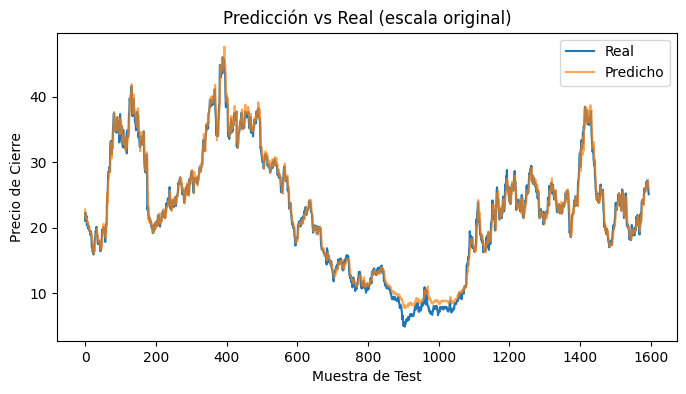

In [103]:
model.eval()
ys_true, ys_pred = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        # yb viene en escala original, así que:
        y_pred = model(xb).cpu().numpy().flatten()
        ys_pred.extend(y_pred)
        ys_true.extend(yb.numpy().flatten())

# Graficar directamente en la escala de precios reales
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(ys_true, label='Real')
plt.plot(ys_pred, label='Predicho', alpha=0.7)
plt.xlabel("Muestra de Test")
plt.ylabel("Precio de Cierre")
plt.title("Predicción vs Real (escala original)")
plt.legend()
plt.show()


Accuracy subida/bajada en Test: 98.43%


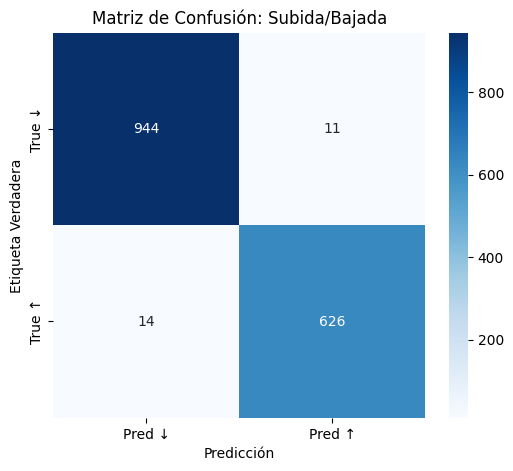

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 1) Reconstruir cierres "previos" al test para obtener la etiqueta de subida/bajada
close_values = df['Close'].values
test_start   = n_train + T
test_len     = len(ys_true)
test_indices = np.arange(test_start, test_start + test_len)
prev_close   = close_values[test_indices - 1]

# 2) Crear etiquetas verdaderas y predichas
true_labels = (ys_true > prev_close).astype(int)
pred_labels = (ys_pred > prev_close).astype(int)

# 3) Calcular accuracy
accuracy = (true_labels == pred_labels).mean()
print(f"Accuracy subida/bajada en Test: {accuracy*100:.2f}%")

# 4) Calcular matriz de confusión
cm = confusion_matrix(true_labels, pred_labels)

# 5) Graficar con seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred ↓','Pred ↑'],
            yticklabels=['True ↓','True ↑'])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión: Subida/Bajada')
plt.show()


